In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import re
import matplotlib.pyplot as plt
import sys
import numpy as np
import warnings
warnings.filterwarnings('ignore')
torch.manual_seed(42)

In [ ]:
def load():
    df_train = pd.read_csv('val.csv')
    df_train['domain'] = df_train.domain.map(lambda x: re.split('\..+', x)[0])
    max_len = min(df_train['domain'].map(len).max(), 512)
    df_train, df_test = train_test_split(df_train, random_state=42, test_size=0.2, stratify=df_train.is_dga)
    return df_train, df_test, max_len

df_train, df_test, max_len = load()

In [ ]:
print(df_train.shape, df_test.shape, max_len.shape)

(8000, 2) (2000, 2) ()


In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
df_train = pd.read_csv('val.csv')
df_test = pd.read_csv('test.csv')

# def trans(x):
#   pattern = '\..+'
#   return re.split(pattern, x)[0]

# df_train['country'] = df_train['domain'].map(trans)

print(df_train.shape, df_test.shape)

df_train['domain'] = df_train.domain.map(lambda x: re.split('\..+', x)[0])
max_len = min(df_train['domain'].map(len).max(), 512)
df_train.head(2)

(10000, 2) (10000, 1)


,domain,is_dga
0,r8s3-zzdxp,1
1,mysolarfocus,0


In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained('bert-base-uncased')
bert = DistilBertModel.from_pretrained("distilbert-base-uncased")

In [ ]:
class DataStorage(Dataset):
  def __init__(self, max_l, tokenizer, df, device):
    self.df = df
    self.max_len = max_l
    self.tokenizer = tokenizer
    self.device = device

  def __getitem__(self, index):
        domain = str(self.df.domain[index])
        inputs = self.tokenizer.encode_plus(
            domain,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True,
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.df.is_dga[index], dtype=torch.long)
        }

  def __len__(self):
        return len(self.df)

In [ ]:
train_data_set = DataStorage(df=df_train, max_l=max_len, tokenizer=tokenizer, device=device)
test_data_set = DataStorage(df=df_test, max_l=max_len, tokenizer=tokenizer, device=device)

In [ ]:
TRAIN_BATCH_SIZE = 5
VALID_BATCH_SIZE = 2


train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

train_loader = DataLoader(train_data_set, **train_params)
test_loader = DataLoader(test_data_set, **train_params)

In [ ]:
class NN(nn.Module):
    def __init__(self, bert):
        super().__init__()
        self.bert = bert
        self.drop = nn.Dropout(0.1)
        self.lin1 = nn.Linear(768, 512)
        self.rel = nn.ReLU()
        self.lin2 = nn.Linear(512, 2)
        self.act = nn.LogSoftmax(dim=1)

    def forward(self, ids, mask):
        x = self.bert(input_ids=ids, attention_mask=mask)[0]
        x = x[:, 0]
        x = self.lin1(x)
        x = self.rel(x)
        x = self.drop(x)
        x = self.lin2(x)
        x = self.act(x)
        return x

In [ ]:
model = NN(bert)
model = model.to(device)
epoch = 1
lr = 1e-05
opt = torch.optim.AdamW(model.parameters(), lr=lr)
loss_f = nn.CrossEntropyLoss()
loss_list = []
steps = []
n_steps = len(train_loader)

for ep in range(epoch):
  for _, data in enumerate(train_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        y = data['targets'].to(device, dtype = torch.long)

        pred = model(ids, mask)

        loss = loss_f(pred, y)

        opt.zero_grad()

        loss.backward()

        opt.step()

        if _%100 == 0:
          loss_list.append(loss.item())
          steps.append(_)
          sys.stdout.write('\r')
          sys.stdout.write(f'Epoch {ep}: {_}/{n_steps} Loss: {loss.item()}')
          sys.stdout.flush()

Epoch 0: 1900/2000 Loss: 0.02539220079779625

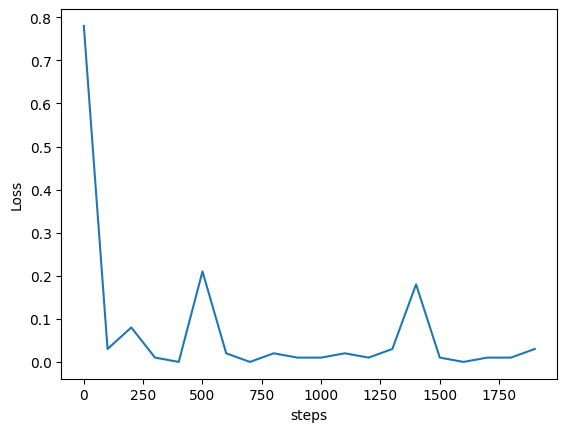

In [ ]:
plt.plot(steps, list(map(lambda x: round(x, 2), loss_list)))
plt.ylabel('Loss')
plt.xlabel('steps')
plt.show()

In [ ]:
def eval(model, df):
  matrix = np.array([[0, 0], [0, 0]])
  with torch.inference_mode():
    for _, data in enumerate(train_loader, 0):
          ids = data['ids'].to(device, dtype = torch.long)
          mask = data['mask'].to(device, dtype = torch.long)
          y = data['targets']
          pred = model(ids, mask).max(axis=1).indices.cpu()
          matrix += confusion_matrix(y, pred)

    true_neg, false_pos, false_neg, true_pos = matrix.ravel()

    accuracy = (true_neg+true_pos) / (true_neg+false_pos+false_neg+true_pos)
    accuracy = round(accuracy, 2)
    prec = round(true_pos/(true_pos + false_pos), 2)
    rec = round(true_pos/(true_pos + false_neg), 2)
    f1 = round((2 * prec * rec)/(prec + rec), 2)
    print(f'True positive: {true_pos}')
    print(f'False positive: {false_pos}')
    print(f'False negative: {false_neg}')
    print(f'True negative: {true_neg}')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {prec}')
    print(f'Recall: {rec}')
    print(f'F1: {f1}')
  return matrix

In [ ]:
matrix = eval(model, train_loader)

True positive: 5333
False positive: 720
False negative: 625
True negative: 5167
Accuracy: 0.89
Precision: 0.88
Recall: 0.9
F1: 0.89


In [ ]:
output_model_file = 'models/pytorch_distilbert_news.bin'
output_vocab_file = 'models/vocab_bert_news.bin'

model_to_save = model
torch.save(model_to_save, output_model_file)
tokenizer.save_pretrained(output_vocab_file)

('/content/models/vocab_bert_news.bin/tokenizer_config.json',
 '/content/models/vocab_bert_news.bin/special_tokens_map.json',
 '/content/models/vocab_bert_news.bin/vocab.txt',
 '/content/models/vocab_bert_news.bin/added_tokens.json',
 '/content/models/vocab_bert_news.bin/tokenizer.json')